## Lyft Challenge!

https://www.udacity.com/lyft-challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pdb
from pathlib import Path

In [24]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def open_image_no_norm(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of ints
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

def show_img(im, figsize=(10,10), ax=None, seg=False, channel=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    new_img = np.copy(im) # Prevent the original image from being modified
    if seg:
        new_img = new_img[:,:,0] # Grab just the red channel from the RGB image
        if channel:
            new_img[new_img != channel] = 0 # Display only the requested classes (roads etc)
    ax.imshow(new_img.astype(np.int32))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

PATH = Path('train')

In [5]:
list(PATH.iterdir())

[PosixPath('train/CameraSeg'),
 PosixPath('train/car_masks_128'),
 PosixPath('train/models'),
 PosixPath('train/tmp'),
 PosixPath('train/road_masks_128'),
 PosixPath('train/train_128'),
 PosixPath('train/train_masks_128'),
 PosixPath('train/CameraRGB')]

In [6]:
RGB_PATH = PATH/'CameraRGB'
list(RGB_PATH.iterdir())[:5]

[PosixPath('train/CameraRGB/5.png'),
 PosixPath('train/CameraRGB/88.png'),
 PosixPath('train/CameraRGB/0.png'),
 PosixPath('train/CameraRGB/128.png'),
 PosixPath('train/CameraRGB/406.png')]

(600, 800, 3)
0.0


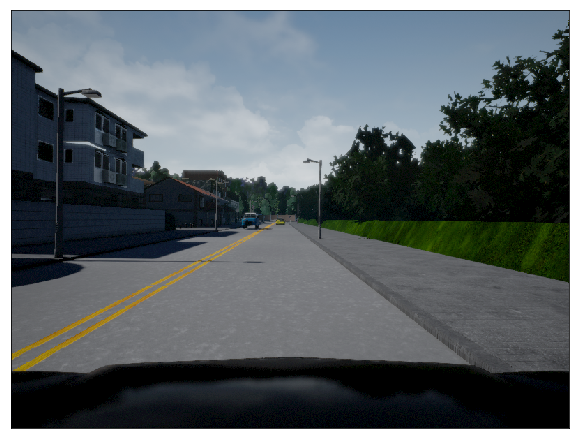

In [25]:
test_RGB_image = open_image_no_norm(next(RGB_PATH.iterdir()))
print(test_RGB_image.shape)
print(test_RGB_image.min())
show_img(test_RGB_image);

In [26]:
seg_PATH = PATH/'CameraSeg'
list(seg_PATH.iterdir())[:5]

[PosixPath('train/CameraSeg/5.png'),
 PosixPath('train/CameraSeg/88.png'),
 PosixPath('train/CameraSeg/0.png'),
 PosixPath('train/CameraSeg/128.png'),
 PosixPath('train/CameraSeg/406.png')]

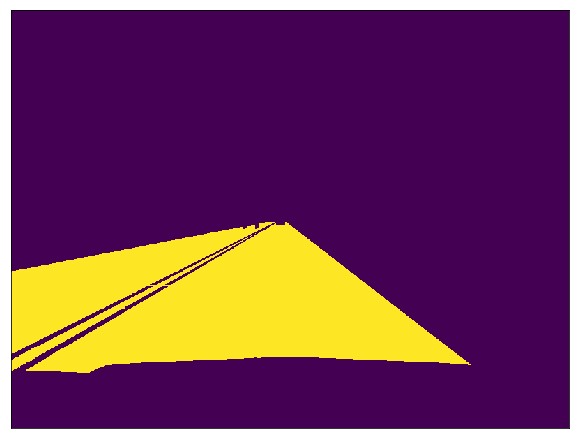

In [27]:
test_seg_image = open_image_no_norm(next(seg_PATH.iterdir()))
show_img(test_seg_image, seg=True, channel=ROADS)

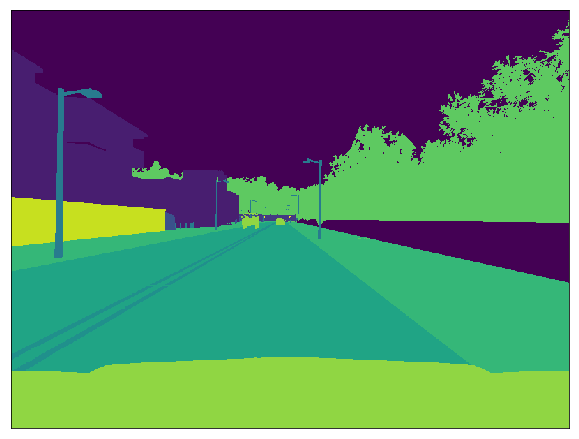

In [28]:
show_img(test_seg_image, seg=True)

Now that I have a feel for how the dataset looks, let's downsize the images for training

In [35]:
# (PATH/'train_masks_128').mkdir(exist_ok=True)
# (PATH/'train_128').mkdir(exist_ok=True)
# (PATH/'car_masks_128').mkdir(exist_ok=True)
# (PATH/'road_masks_128').mkdir(exist_ok=True)

## Convert segmented images to just a specific channel

In [30]:
# Path('train/road_masks_128/5.png')
# filter_segmented(Path('train/train_masks_128/5.png'))

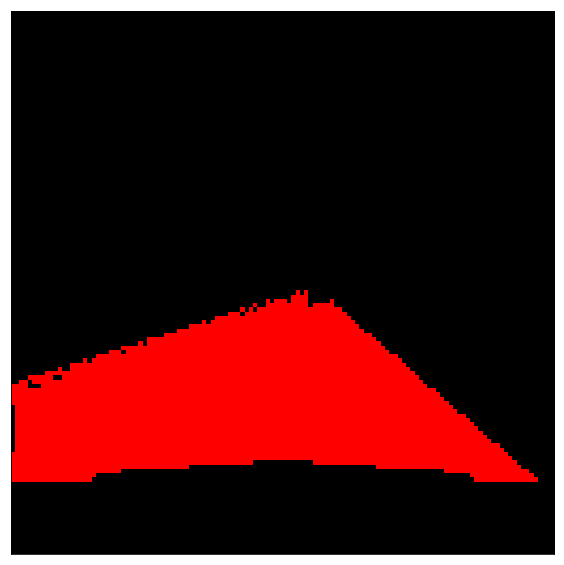

In [34]:
test_seg_image = open_image_no_norm('train/road_masks_128/435.png')
show_img(test_seg_image);

## Resize images

In [48]:
def resize_mask(filename, size=128):
    Image.open(filename).resize((size,size)).save((filename.parent.parent)/'train_masks_128'/filename.name)
    
def resize_img(filename, size=128):
    Image.open(filename).resize((size,size)).save((filename.parent.parent)/'train_128'/filename.name)
    
def filter_segmented(filename, values=[ROADS, ROAD_LINES], folder_name=None):
    '''Filters out pixels that are not the specified values (in the red color channel)'''
    assert folder_name is not None, 'Please supply a folder to save the images in!'
#     if not isinstance(values, list):
#         values = [values] # TODO: is this line breaking things?

    test_img = Image.open(filename)
    img_np = np.array(test_img)
    
    img_np_R = img_np[:,:,0] # Pull out R channel

    for value in values: # Trim pixels as desired
        img_np_R[img_np_R == value] = 255

    img_np_R[img_np_R != 255] = 0
    
    # Crop out hood
    if VEHICLES in values:
        h,w = img_np_R.shape
        img_np_R[int(.82*h):h, :] = 0

    # Save to disk
    image = Image.fromarray(img_np, 'RGB')
    image.save((filename.parent.parent)/folder_name/filename.name) # hardcoded folder name for now

In [49]:
masks = list(seg_PATH.iterdir())
imgs = list(RGB_PATH.iterdir())

# with ThreadPoolExecutor(8) as e: e.map(resize_mask, masks)
# with ThreadPoolExecutor(8) as e: e.map(resize_img, imgs)

small_masks_PATH = PATH/'train_masks_128'

small_masks = list(small_masks_PATH.iterdir())
for file in small_masks:
#     filter_segmented(file, [ROADS, ROAD_LINES], 'road_masks_128')
    filter_segmented(file, [VEHICLES], 'car_masks_128')

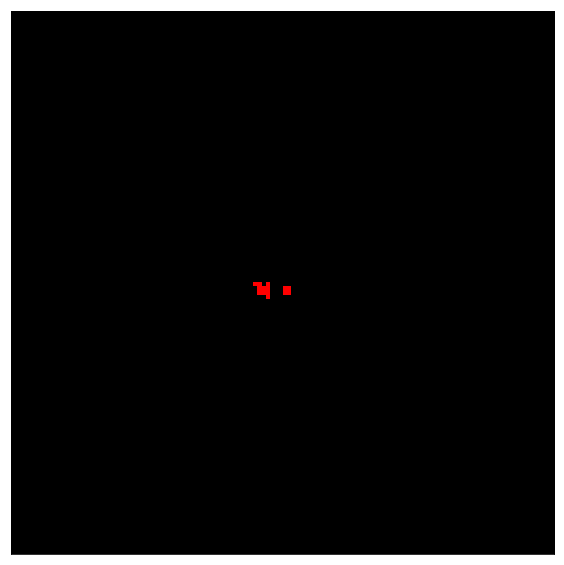

In [52]:
test_seg_image = open_image_no_norm('train/car_masks_128/1.png')
show_img(test_seg_image);

In [53]:
TRAIN_DN = 'train_128'
MASKS_DN = 'train_masks_128'
CAR_MASKS = 'car_masks_128'
ROAD_MASKS = 'road_masks_128'
sz = 128
bs = 64

list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('train/train_masks_128/5.png'),
 PosixPath('train/train_masks_128/88.png'),
 PosixPath('train/train_masks_128/0.png'),
 PosixPath('train/train_masks_128/128.png'),
 PosixPath('train/train_masks_128/406.png')]

In [66]:
class MatchedFilesDatset(FilesDataset):
    def __init__(self, filenames, y, transform, path):
        assert(len(filenames == len(y)))
        self.y = y
        super().__init__(filenames, transform, path)
        
    def get_y(self, i): return open_image_no_norm(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

In [67]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/ROAD_MASKS).iterdir()))

len(x_names), len(y_names)

(1000, 1000)

In [68]:
val_idxs = list(range(len(x_names)//5)) # 20% validation split
((val_x, trn_x),(val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names) # split the in/out pairs the same

In [69]:
len(val_x),len(trn_x),trn_x[:2]

(200,
 800,
 array([PosixPath('train/train_128/284.png'), PosixPath('train/train_128/595.png')], dtype=object))

In [70]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [71]:
transforms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDatset, (trn_x,trn_y), (val_x,val_y), transforms, path='')
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [72]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

In [73]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
# learn.summary()

In [74]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [75]:
flatten_channel = Lambda(lambda x: x[:,0])

In [76]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [77]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

epoch      trn_loss   val_loss   <lambda>                      
    0      -5153.640792 -68309113241.6 0.032086  



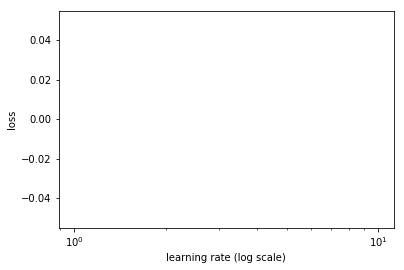

In [205]:
learn.lr_find()
learn.sched.plot()

In [206]:
lr=4e-2

In [207]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>                      
    0      -1045.679555 -18080.016719 0.337511  
    1      -8905.703471 -35409.081719 0.662747                 
    2      -24709.661128 -63586.606562 0.697817                
    3      -45220.354129 -102257.021562 0.002869               
    4      -65230.786004 -118017.932812 0.000771               



[array([-118017.93281]), 0.00077056884765625]

In [208]:
learn.save('tmp')

In [78]:
learn.load('tmp')

In [79]:
py,ay = learn.predict_with_targs()

In [80]:
ay.shape

(200, 128, 128)

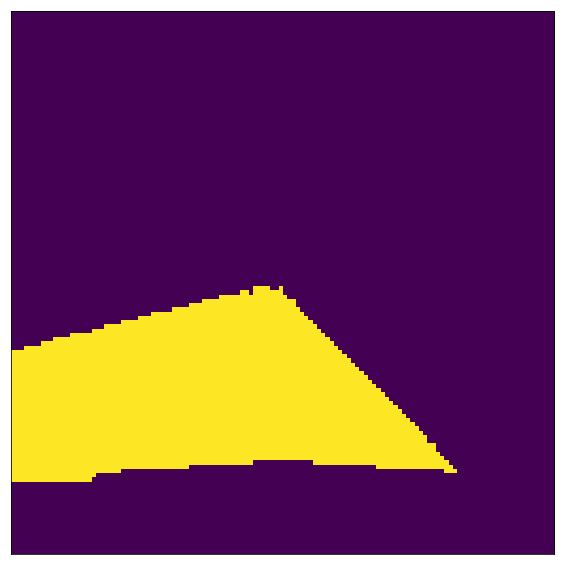

In [81]:
show_img(ay[0]);

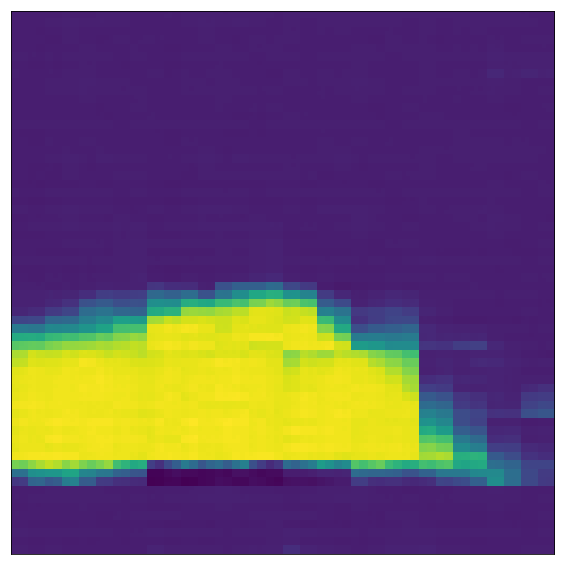

In [82]:
show_img(py[0]);

In [96]:
py[0][120]

array([177.75375, 178.2156 , 176.8425 , 177.30014, 169.90054, 170.35196, 167.80356, 168.25232, 169.94183,
       170.39282, 169.90402, 170.3536 , 171.2649 , 171.71832, 168.86502, 169.31442, 177.83057, 178.29184,
       176.34506, 176.80142, 173.3977 , 173.85257, 171.43365, 171.88611, 173.30063, 173.75522, 172.89633,
       173.34897, 179.93912, 180.40292, 177.98642, 178.44757, 170.14645, 170.59863, 169.719  , 170.16815,
       161.99707, 162.43887, 159.83102, 160.2702 , 166.09949, 166.54605, 166.36035, 166.80603, 165.53638,
       165.98325, 162.84021, 163.28256, 181.59946, 182.06488, 180.42935, 180.89127, 174.6929 , 175.14917,
       172.60083, 173.05505, 178.67065, 179.13202, 178.66031, 179.12036, 187.81195, 188.28552, 185.95175,
       186.42355, 173.32932, 173.7851 , 172.67636, 173.129  , 160.2185 , 160.6576 , 158.48682, 158.92432,
       166.04095, 166.48734, 166.15991, 166.60507, 163.82623, 164.27072, 161.3847 , 161.82529, 179.71533,
       180.17853, 178.53363, 178.9932 , 173.78